In [101]:
import numpy as np # linear algebra

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


In [129]:
datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)

The Data Structure
Incorect: MC= 2500 , mmc =2500
With_mask: com = 789 , simple = 4000
Without_mask: com= 747, simple= 4000

First we will use ImageDataGenerator a class in the Keras library for deep learning, which is used to preprocess image data. The flow_from_directory method is used to generate batches of image data from a directory containing subdirectories of images, with each subdirectory representing a class label. The method takes the path to the directory containing the images as an argument.

In [137]:
data = datagen.flow_from_directory(
    "FMD_DATASET",
    target_size=(150, 150),
    batch_size=500,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 14536 images belonging to 3 classes.


DATA DETAILS

In [131]:
counts = np.bincount(data.labels)
print("classes: ",data.class_indices,
      "\nimage shape: ", data.image_shape,
      "\n  * class 'incorrect_mask' (0): ", counts[0],
      "\n  * class 'with_mask' (1): ", counts[1],
      "\n  * class 'without_mask' (2): ", counts[2],)

classes:  {'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2} 
image shape:  (150, 150, 3) 
  * class 'incorrect_mask' (0):  5000 
  * class 'with_mask' (1):  4789 
  * class 'without_mask' (2):  4747


In [132]:
data.image_shape

(150, 150, 3)

In [138]:
data.labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

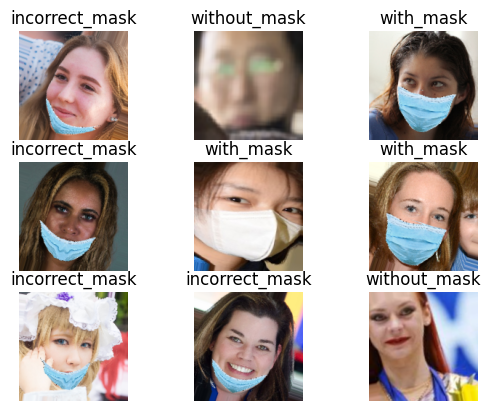

In [63]:
image_batch, labels_batch = data.next()

for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i])
      label = labels_batch[i]
      if np.array_equal(label, np.array([1., 0., 0.])):
            plt.title('incorrect_mask')
      elif np.array_equal(label, np.array([0., 1., 0.])):
            plt.title('with_mask')
      else:
            plt.title('without_mask')
      plt.axis("off")

In [88]:
data_pca = datagen.flow_from_directory("FMD_DATASET", target_size=(28,28),
                                         batch_size=500,color_mode='rgba',shuffle='True', seed=42)
max_k = 0
for i in range(5):
    x_batch, y_batch = next(data_pca)
    reduce_data = x_batch.reshape(x_batch.shape[0], -1)
    pca = PCA()
    pca.fit(reduce_data)
    var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
    k = np.argmax(var_cumu>95)
    max_k = k if k>max_k else max_k
print("max k for 95%: ", max_k)


Found 14536 images belonging to 3 classes.
max k for 95%:  136


In [116]:
from sklearn.model_selection import RandomizedSearchCV
def bestParam(model, param_grid):
    hyper_data = datagen.flow_from_directory("FMD_DATASET",target_size=(28,28),
                                          batch_size=5000,color_mode='rgba',shuffle='True',seed=42)
    pca = PCA(n_components=max_k)
    x_batch, y_batch = next(hyper_data)
    reduce_data = x_batch.reshape(x_batch.shape[0], -1)
    y_batch = np.argmax(y_batch, axis=1)
    data_k_features = pca.fit_transform(reduce_data)
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=5, cv=5, n_jobs=-1)
    random_search.fit(data_k_features, y_batch)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    return random_search.best_params_



In [139]:
# prepare data_train
data_train = datagen.flow_from_directory("FMD_DATASET",target_size=(28,28),
                                          batch_size=11000,color_mode='rgba',shuffle='True',seed=42)
pca = PCA(n_components=max_k)
x_train, y_train = next(data_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.argmax(y_train, axis=1)
data_k_features_train = pca.fit_transform(x_train)

# prepare data_test
x_test, y_test = next(data_train)
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = np.argmax(y_test, axis=1)
data_k_features_test = pca.fit_transform(x_test)

Found 14536 images belonging to 3 classes.


In [140]:
print("x_train: ", x_train.shape, "y_train: ", y_train.shape, "x_test: ", x_test.shape, "y_test: ", y_test.shape)

x_train:  (11000, 3136) y_train:  (11000,) x_test:  (3536, 3136) y_test:  (3536,)


In [117]:
def classifier(model):
    model.fit(data_k_features_train, y_train)
    y_pred_train = model.predict(data_k_features_train)
    print("Accuracy train: ", accuracy_score(y_train, y_pred_train))
    y_pred_test = model.predict(data_k_features_test)
    print("Accuracy test: ", accuracy_score(y_test, y_pred_test))

In [118]:
param_grid_sgd = {'loss': ['perceptron', 'squared_epsilon_insensitive'],
              'penalty': ['l2','l1','elasticnet',None],
              'alpha': [0.01, 0.1, 0.2],
              'tol': [0.001,0.01,0.1]
             }
sgd = SGDClassifier(max_iter=1000)
sgd_param = bestParam(sgd, param_grid_sgd)
sgd = SGDClassifier(max_iter=1000, **sgd_param)
classifier(sgd)

Found 14536 images belonging to 3 classes.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before

Best parameters:  {'tol': 0.001, 'penalty': None, 'loss': 'perceptron', 'alpha': 0.01}
Best score:  0.9014
Accuracy train:  0.9085
Accuracy test:  0.3915343915343915


In [127]:
param_grid_rf = {
              'n_estimators': [50, 100, 500],
              'max_depth': [10, 50, 100]
             }
rf_tmp = RandomForestClassifier()
rf_param = bestParam(rf_tmp, param_grid_rf)
rf = RandomForestClassifier(**rf_param)
classifier(rf)

Found 14536 images belonging to 3 classes.
Best parameters:  {'n_estimators': 500, 'max_depth': 100}
Best score:  0.866
Accuracy train:  1.0
Accuracy test:  0.41556437389770723
